In [2]:
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import netCDF4
import xarray as xr
import dask

In [3]:
proj_path = '/Users/etriesch/dev/ocean-carbon-sampling/'
crs = 'epsg:4326'
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

In [4]:
YEAR_LOOKBACK_MIN = 2016
YEAR_LOOKBACK_MAX = 2019

## Read and clean ship data (LDEO)

In [5]:
# Read in data
df = pd.read_csv(proj_path + 'data/LDEO_Database_V2019.csv', dtype={'FILENAME': str})

In [6]:
# Clean
df.columns = df.columns.str.lower()

# make date columns
df.loc[:,'date'] = pd.to_datetime(df['month/day/year'])
df.loc[:,'year'] = df.date.dt.year

# subset to years of interest
df_sub = df.loc[(df.year >= YEAR_LOOKBACK_MIN) & (df.year <= YEAR_LOOKBACK_MAX)]

In [7]:
# Northeast Pacific subset
min_lat, max_lat = 29, 48
min_lon, max_lon = -140, -116
p_mask_lon = (df_sub.lon >= min_lon) & (df_sub.lon <= max_lon)
p_mask_lat = (df_sub.lat >= min_lat) & (df_sub.lat <= max_lat)
df_pac = df_sub[p_mask_lon & p_mask_lat]

#Northwest Atlantic subset
min_lat, max_lat = 20, 48
min_lon, max_lon = -97, -60
a_mask_lon = (df_sub.lon >= min_lon) & (df_sub.lon <= max_lon)
a_mask_lat = (df_sub.lat >= min_lat) & (df_sub.lat <= max_lat)
df_atl = df_sub[a_mask_lon & a_mask_lat]

### Visualize

<AxesSubplot:>

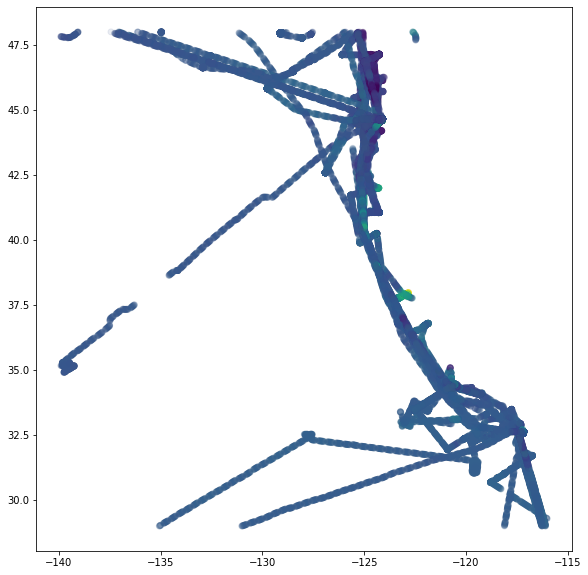

In [10]:
# ship data - pacific
geometry = [Point(xy) for xy in zip(df_pac['lon'], df_pac['lat'])]
geo_df_pac = gpd.GeoDataFrame(df_pac, crs=crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(10,10))
geo_df_pac.plot(ax=ax, column='pco2_teq', alpha=0.1)

<AxesSubplot:>

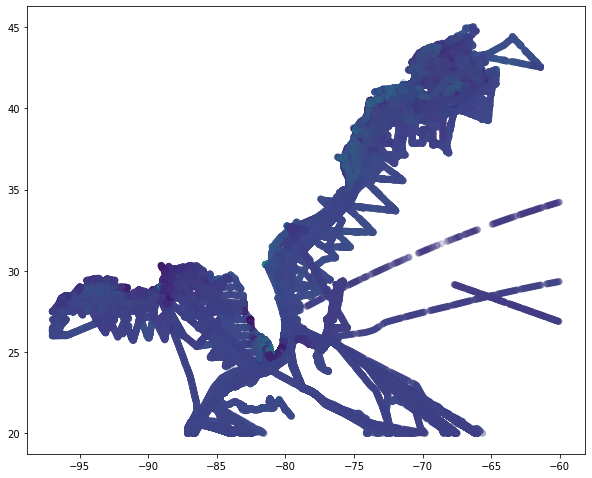

In [11]:
# ship data - atlantic
geometry = [Point(xy) for xy in zip(df_atl['lon'], df_atl['lat'])]
geo_df_atl = gpd.GeoDataFrame(df_atl, crs=crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(10,10))
geo_df_atl.plot(ax=ax, column='pco2_teq', alpha=0.1)

# Read and clean mooring data

In [5]:
mooring_path = proj_path + 'data/pco2_moorings/'
m_files = [f for f in os.listdir(proj_path + 'data/pco2_moorings') 
           if f.endswith('.csv')]
m_files.sort()

In [115]:
# read in mooring data
m = pd.DataFrame()
for f in m_files:
    skip=4
    d = pd.read_csv(mooring_path + f, skiprows=skip)
    while (d.columns[0] not in ['Mooring', 'Mooring Name']) & (skip >= 0):
        d = pd.read_csv(mooring_path + f, skiprows=skip)
        skip -= 1
    # clean up columns
    d.columns = d.columns.str.lower()
    d.columns = d.columns.str.replace('[()%]','',regex=True)
    d.columns = d.columns.str.replace('  ', ' ').str.replace(' ','_')
    d.columns = d.columns.str.replace(r'_c$', '',regex=True).str.replace(r'_uatm$', '',regex=True)
    d.columns = d.columns.str.replace(r'_umol/mol$', '',regex=True).str.replace(r'_mmol/mol$', '',regex=True)
    d.columns = d.columns.str.replace(r'_ntu$', '',regex=True).str.replace(r'_hpa$', '',regex=True)
    d.columns = d.columns.str.replace(r'_ug/l$', '',regex=True).str.replace(r'umol/kg$', '',regex=True)
    m = pd.concat([m, d], axis=0)

In [121]:
# Clean dataset
# drop unnamed variables
m = m.loc[:, ~m.columns.str.startswith('unnamed')]

# clean up mooring names
m.loc[m['mooring_name'].isna(), 'mooring_name'] = m.loc[m['mooring_name'].isna(), 'mooring']
m.loc[m['mooring_name'].isin(['MS_89W_30N', 'CoastalMS', 'COASTALMS_88W_30N', 'COASTALMS_89W_30N']), 'mooring_name'] = 'COASTALMS_89W_30N'
m.loc[m['mooring_name'].isin(['GRAYSRF_81W_31N','GraysReef','GraysRf_81W_31N', 'GraysReef_81W_31N']), 'mooring_name'] = 'GRAYSRF_81W_31N'
# drop all other rows with missing mooring names (it's missing in all columns)
m = m.loc[m.mooring_name.notna()]

# make new variables
m.loc[:,'date'] = pd.to_datetime(m.date)
m.loc[:,'year'] = m.date.dt.year
m.loc[:, 'month'] = m.date.dt.month
m.loc[:, 'moye'] = (m['year'].astype(str) + m['month'].astype(str).apply(lambda x: x.zfill(2)))

# subset to variables/years of interest and clean those
params = ['xco2_sw_wet', 'xco2_sw_dry', 'fco2_sw_sat', 'pco2_sw_sat']
m[params] = m[params].apply(pd.to_numeric, errors='coerce')
m[params] = m[params].replace({-999:np.nan})

# subset years and moorings
m_sub = m.loc[(m.year >= YEAR_LOOKBACK_MIN) & (m.year <= YEAR_LOOKBACK_MAX)]

drop_moorings = ['GRAYSRF_81W_31N', 'COASTALMS_89W_30N']
m_sub = m_sub.loc[~m.mooring_name.isin(drop_moorings)]

## TODO - do i need to look into the qc flag for `pco2_sw_sat`?

In [130]:
# summarize by month
param = 'pco2_sw_sat'
m_summ = m_sub.groupby(['mooring_name', 'moye', 'year', 'month'])[param].describe().reset_index()
m_summ = m_summ.sort_values(['mooring_name','moye'])

In [143]:
# get max monthly std per mooring
summ_monthly_std = m_summ.groupby('mooring_name')['std'].agg(['max', 'mean']).reset_index()
summ_monthly_std

,mooring_name,max,mean
0,CCE1_122W_33N,18.526291,6.621411
1,CCE2_121W_34N,81.480062,31.833434
2,CHEECA_80W_25N,82.466651,41.438164
3,LAPUSH_125W_48N,94.351961,51.158856
4,NH10_124W_44N,120.283149,35.566321
5,NH_70W_43N,58.508688,24.280917


In [144]:
# get max annual std per mooring
summ_annual_std = m_sub.groupby(['mooring_name', 'year'])[param].describe().reset_index()
summ_annual_std = summ_annual_std.groupby('mooring_name')['std'].agg(['max', 'mean']).reset_index()
summ_annual_std

,mooring_name,max,mean
0,CCE1_122W_33N,17.548314,16.106794
1,CCE2_121W_34N,47.878338,42.029957
2,CHEECA_80W_25N,94.259806,70.543195
3,LAPUSH_125W_48N,88.106614,83.236647
4,NH10_124W_44N,59.929228,47.588192
5,NH_70W_43N,51.985737,47.513018


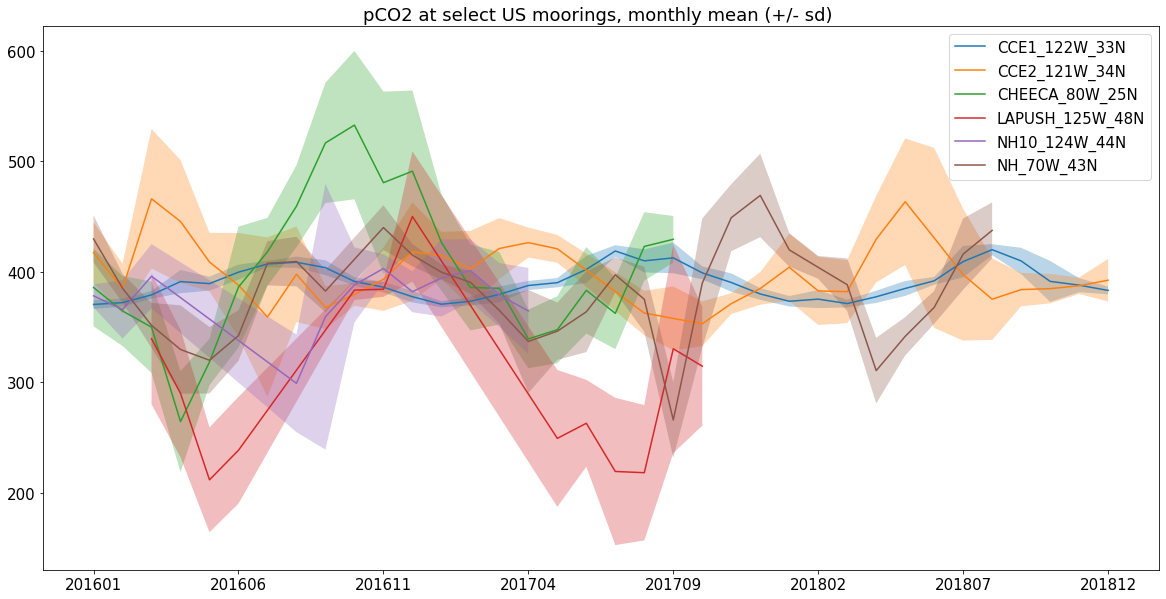

In [146]:
# plot
fit, ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 15})

moorings = m_summ.mooring_name.drop_duplicates().values
for mo in moorings:
    temp = m_summ.loc[m_summ.mooring_name==mo]
    plt.plot(temp.moye, temp['mean'], label=mo)
#     plt.fill_between(temp.moye, temp['25%'], temp['75%'], alpha=0.3) #IQR
#     plt.fill_between(temp.moye, temp['min'], temp['max'], alpha=0.3) #Range
    plt.fill_between(temp.moye, temp['mean']-temp['std'], temp['mean']+temp['std'], alpha=0.3) #STD

axis_spacing = m_summ.moye.drop_duplicates().sort_values().to_list()[::5]
plt.xticks(axis_spacing)
plt.title('pCO2 at select US moorings, monthly mean (+/- sd) ')
plt.legend()
plt.show()